 **Homework 2**  \\
**Name**: Ahmed Ali \\
**Course**: Computational Intelligence (Spring 2022) \\


# Setup environment

In [1]:
#install required libraries
!pip install cvxpy
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn
from scipy.linalg import null_space
from mpl_toolkits.mplot3d import Axes3D

**Helper functions**

In [2]:
def skew(vector):
    """
    This function returns the skew symmetric form of a vector
    for the cross product between two vectors
    Retrieved from stackoverflow 
    """
    if isinstance(vector, np.ndarray):
        vector = vector.tolist()
    return np.array([[0, -vector[2][0], vector[1][0]], 
                     [vector[2][0], 0, -vector[0][0]], 
                     [-vector[1][0], vector[0][0], 0]])
    

def normalize(v):
  """
    This function returns the normalized vector of input vector 
  """
  norm = np.linalg.norm(v)
  if norm == 0: 
    return v
  return v / norm

#Task 1

I will formulate this task as feasibility problem.

In [43]:
#___________________________________Constants___________________________________
m = 5 # robot mass
g = np.array([[0],[0],[-9.8]])  # gravity vector
r_c = np.array([[2],[2],[4]]) #center of mass position (assumed to be at the center)
mu = 0.5 #friction coefficient
#position of each foot
r_1 = np.array([0,0,0])
r_2 = np.array([4,0,0])
r_3 = np.array([4,4,0])
r_4 = np.array([0,4,0])

E_t = np.array([[1,0],[0,1],[0,0]]) #basis of tangential plane
e_n = np.array([0,0,1]) #vector normal to tangential plane 

#___________________________________Decision Varaibel___________________________
#define each force as decision variable of R3
f1= cp.Variable((3,1)) 
f2= cp.Variable((3,1))
f3= cp.Variable((3,1))
f4= cp.Variable((3,1))
#define x variable as vector of all reaction forces
x = cp.vstack([f1,f2,f3,f4])


#___________________________________Equality constraints________________________
#define A matrix that contains all equality constraints          
A = np.block([
              [   np.eye(3)   ,      np.eye(3),      np.eye(3),      np.eye(3)],
              [skew(r_1 - r_c),skew(r_2 - r_c),skew(r_3 - r_c),skew(r_4 - r_c)]
              ])

#define b vector: RHS of equality constaints
b = np.block([
              [-m*g],
              [np.zeros((3,1))] 
             ])

#___________________________________Inequality constraints_____________________
#define all inequality constraints  
constraints=[A@x ==b ]
for i in range(0,12,3):
  constraints+=[(cp.norm( E_t.T@x[i:i+3])<=mu*e_n.T@x[i:i+3])]


#___________________________Problem formulation usign cvxpy_____________________
obj_cp = cp.Minimize(0)        #define cost function as feasbility problem
proj = cp.Problem(obj_cp,constraints)   #define problem with constraints
result = proj.solve()       #solve problem

#_____________________Results______________________
print(proj.status)  
print("\nf1  is: ",f1.value.T)
print("\nf2  is: ",f2.value.T)
print("\nf3  is: ",f3.value.T)
print("\nf4  is: ",f4.value.T)

optimal

f1  is:  [[-0.12746283 -0.12746283 12.12253717]]

f2  is:  [[ 0.12746283  0.12746283 12.37746283]]

f3  is:  [[ 0.12746283  0.12746283 12.37746283]]

f4  is:  [[-0.12746283 -0.12746283 12.12253717]]


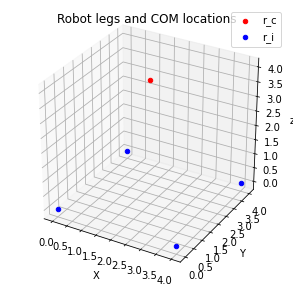

In [45]:
#visualize the robot
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r_c[0],r_c[1],r_c[2], marker="o", color="red",label="r_c")
ax.scatter(r_1[0],r_1[1],r_1[2], marker="o", color="blue",label="r_i")
ax.scatter(r_2[0],r_2[1],r_2[2], marker="o", color="blue")
ax.scatter(r_3[0],r_3[1],r_3[2], marker="o", color="blue")
ax.scatter(r_4[0],r_4[1],r_4[2], marker="o", color="blue")
ax.set_title("Robot legs and COM locations")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("z")
ax.legend(loc="best")
plt.show()

**Comment:** The result shows that there exist reaction forces that allow the
robot to maintain static stability on **horizontal** ground.

#Task 2

This task is to check stability of robot on tilted ground

In [47]:
#___________________________Constants___________________________________________
m = 5 # robot mass
g = np.array([[0],[0],[-9.8]])  # gravity vector
mu = 2 #friction coefficient


#generate random normal vector 
e_n = np.array([[0],[0],[1]]) +  randn(3,1)
e_n = normalize(e_n)

E_t = null_space(e_n.T) #basis of tilted tangential plane as Left_Null(e_n)
#position of each foot as random point on tilted plane
r_1 = np.dot(E_t, np.random.rand(2,1))  
r_2 = np.dot(E_t, np.random.rand(2,1)) 
r_3 = np.dot(E_t, np.random.rand(2,1)) 
r_4 = np.dot(E_t, np.random.rand(2,1)) 
r_c = (r_1 + r_2 + r_3 + r_4 )/ 4
#___________________________Decision Variables__________________________________
#define each force as decision variable of R3
f1= cp.Variable((3,1)) 
f2= cp.Variable((3,1))
f3= cp.Variable((3,1))
f4= cp.Variable((3,1))
#define x variable as vector of all reaction forces
x = cp.vstack([f1,f2,f3,f4])


#___________________________Equality Constraints________________________________
#define A matrix that contains all equality constraints          
A = np.block([
              [   np.eye(3)   ,      np.eye(3),      np.eye(3),      np.eye(3)],
              [skew(r_1 - r_c),skew(r_2 - r_c),skew(r_3 - r_c),skew(r_4 - r_c)]
              ])

#define b vector: RHS of equality constaints
b = np.block([
              [-m*g],
              [np.zeros((3,1))] 
             ])

#___________________________Inequality Constraints______________________________ 
#define all inequality constraints  
constraints=[A@x ==b ]
for i in range(0,12,3):
  constraints+=[(cp.norm( E_t.T@x[i:i+3])<=mu*e_n.T@x[i:i+3])]


#___________________________Problem formulation usign cvxpy______________________
obj_cp = cp.Minimize(0)        #define cost function as feasbility problem
proj = cp.Problem(obj_cp,constraints )   #define problem with constraints
result = proj.solve()       #solve problem

#________________________________________Results_________________________________
print("problem is ",proj.status)
print("\nf1  is: ",f1.value.T)
print("\nf2  is: ",f2.value.T)
print("\nf3  is: ",f3.value.T)
print("\nf4  is: ",f4.value.T)

problem is  optimal

f1  is:  [[ 7.32913490e-13 -5.23870474e-13  1.22500000e+01]]

f2  is:  [[-2.47703537e-12  5.88103996e-13  1.22500000e+01]]

f3  is:  [[ 1.44329022e-12 -2.81008222e-13  1.22500000e+01]]

f4  is:  [[3.00844317e-13 2.16764777e-13 1.22500000e+01]]


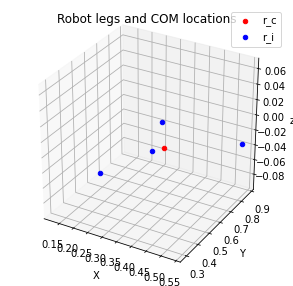

In [48]:
#visualize the robot
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r_c[0],r_c[1],r_c[2], marker="o", color="red",label="r_c")
ax.scatter(r_1[0],r_1[1],r_1[2], marker="o", color="blue",label="r_i")
ax.scatter(r_2[0],r_2[1],r_2[2], marker="o", color="blue")
ax.scatter(r_3[0],r_3[1],r_3[2], marker="o", color="blue")
ax.scatter(r_4[0],r_4[1],r_4[2], marker="o", color="blue")
ax.set_title("Robot legs and COM locations")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("z")
ax.legend(loc="best")
plt.show()

**Comment:** The result sometimes becomes feasible and sometimes not. The main constraint that make it fails is friction cone, which make sense since the random generated tilted plane can be too steep that robot will slide on it. However, there exist reaction forces, in general, that allow the
robot to maintain static stability on **tilted** ground.

#Task 3

We will assume that the $f_4$ stands on vertical wall.

In [49]:
#___________________________________________Constants___________________________
m = 5 # robot mass
g = np.array([[0],[0],[-9.8]])  # gravity vector
r_c = np.array([[2],[2],[4]]) #center of mass position
mu = 0.5 #friction coefficient
#position of each foot
r_1 = np.array([0,0,0])   
r_2 = np.array([4,0,0])
r_3 = np.array([4,4,0])
r_4 = np.array([0,4,5]) #leg standing on vertical wall

#___________________________________________Basis_______________________________
E_t = np.array([[1,0],[0,1],[0,0]]) #basis of tangential plane
e_n = np.array([0,0,1]) #vector normal to tangential plane 

#___________________________________________Decision Varaibel___________________
#define each force as decision variable of R3
f1= cp.Variable((3,1)) 
f2= cp.Variable((3,1))
f3= cp.Variable((3,1))
f4= cp.Variable((3,1))
#define x variable as vector of all reaction forces
x = cp.vstack([f1,f2,f3,f4])


#___________________________________________Equality constraints________________
#define A matrix that contains all equality constraints          
A = np.block([
              [   np.eye(3)   ,      np.eye(3),      np.eye(3),      np.eye(3)],
              [skew(r_1 - r_c),skew(r_2 - r_c),skew(r_3 - r_c),skew(r_4 - r_c)]
              ])

#define b vector: RHS of equality constaints
b = np.block([
              [-m*g],
              [np.zeros((3,1))] 
             ])

#________________________________Inequality constraints_________________________
#define all inequality constraints  
constraints=[A@x ==b ]
for i in range(0,12,3):
  if i ==9:
    constraints+=[(cp.norm( e_n.T@x[i:i+3])<=mu*E_t.T@x[i:i+3])]
  else:
    constraints+=[(cp.norm( E_t.T@x[i:i+3])<=mu*e_n.T@x[i:i+3])]


#_________________________Problem formulation usign cvxpy_______________________
obj_cp = cp.Minimize(0)        #define cost function as feasbility problem
proj = cp.Problem(obj_cp,constraints)   #define problem with constraints
result = proj.solve()       #solve problem

#_______________________________________Results_________________________________
print(proj.status)  
print("\nf1  is: ",f1.value.T)
print("\nf2  is: ",f2.value.T)
print("\nf3  is: ",f3.value.T)
print("\nf4  (stands on vertical wall) is:",f4.value.T)

optimal

f1  is:  [[-2.86143428 -2.86143427 24.42927064]]

f2  is:  [[-0.0983017 -0.0983017 12.1516983]]

f3  is:  [[-0.0983017 -0.0983017 12.1516983]]

f4  (stands on vertical wall) is: [[3.05803768 3.05803767 0.26733276]]


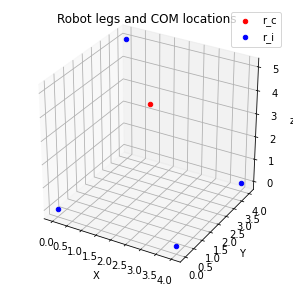

In [50]:
#visualize the robot
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r_c[0],r_c[1],r_c[2], marker="o", color="red",label="r_c")
ax.scatter(r_1[0],r_1[1],r_1[2], marker="o", color="blue",label="r_i")
ax.scatter(r_2[0],r_2[1],r_2[2], marker="o", color="blue")
ax.scatter(r_3[0],r_3[1],r_3[2], marker="o", color="blue")
ax.scatter(r_4[0],r_4[1],r_4[2], marker="o", color="blue")
ax.set_title("Robot legs and COM locations")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("z")
ax.legend(loc="best")
plt.show()

**Comment:** The problem is feasible so the robot can maintain static equilibrium when one of its legs is pushes againt **vertical** wall.

#Task 4

One of the robot legs $f_4$ is nailed to ground, so this leg will not have a friction cone constraint.

In [52]:
#____________________________Constants__________________________________________
m = 5 # robot mass
g = np.array([[0],[0],[-9.8]])  # gravity vector
r_c = np.array([[2],[2],[4]]) #center of mass position
mu = 0.6 #friction coefficient
#position of each foot
r_1 = np.array([0,0,0])
r_2 = np.array([4,0,0])
r_3 = np.array([4,4,0])
r_4 = np.array([0,4,0])

#_________________________________Basis_________________________________________
E_t = np.array([[1,0],[0,1],[0,0]]) #basis of tangential plane
e_n = np.array([0,0,1]) #vector normal to tangential plane 

#__________________________________Decision Varaibel____________________________
#define each force as decision variable of R3
f1= cp.Variable((3,1)) 
f2= cp.Variable((3,1))
f3= cp.Variable((3,1))
f4= cp.Variable((3,1))
#define x variable as vector of all reaction forces
x = cp.vstack([f1,f2,f3,f4])


#____________________________________Equality constraints_______________________
#define A matrix that contains all equality constraints          
A = np.block([
              [   np.eye(3)   ,      np.eye(3),      np.eye(3),      np.eye(3)],
              [skew(r_1 - r_c),skew(r_2 - r_c),skew(r_3 - r_c),skew(r_4 - r_c)]
              ])

#define b vector: RHS of equality constaints
b = np.block([
              [-m*g],
              [np.zeros((3,1))] 
             ])

#________________________________Inequality constraints_________________________
#define all inequality constraints  
constraints=[A@x ==b ]
for i in range(0,9,3): #we neglect last constraint
  constraints+=[(cp.norm( E_t.T@x[i:i+3])<=mu*e_n.T@x[i:i+3])]

#________________________Problem formulation usign cvxpy________________________
obj_cp = cp.Minimize(0)        #define cost function as feasbility problem
proj = cp.Problem(obj_cp,constraints)   #define problem with constraints
result = proj.solve()       #solve problem

#__________________________________________Results______________________________
print(proj.status)  
print("f1  is: ",f1.value.T)
print("\nf2  is: ",f2.value.T)
print("\nf3  is: ",f3.value.T)
print("\nf4  is: ",f4.value.T)

optimal
f1  is:  [[1.06604002e-05 1.06604002e-05 5.10940994e-02]]

f2  is:  [[-1.58698416 -1.58698416 10.66301584]]

f3  is:  [[-1.58698416 -1.58698416 10.66301584]]

f4  is:  [[ 3.17395766  3.17395766 27.62287422]]


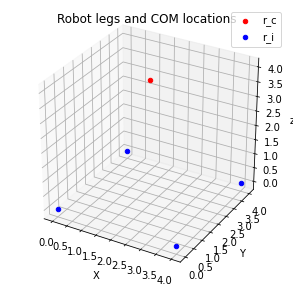

In [53]:
#visualize the robot
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r_c[0],r_c[1],r_c[2], marker="o", color="red",label="r_c")
ax.scatter(r_1[0],r_1[1],r_1[2], marker="o", color="blue",label="r_i")
ax.scatter(r_2[0],r_2[1],r_2[2], marker="o", color="blue")
ax.scatter(r_3[0],r_3[1],r_3[2], marker="o", color="blue")
ax.scatter(r_4[0],r_4[1],r_4[2], marker="o", color="blue")
ax.set_title("Robot legs and COM locations")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("z")
ax.legend(loc="best")
plt.show()

**Comment:** The problem is feasible so the robot can maintain static equilibrium when one of its legs is **nailed to the ground**.